In [1]:
# Install required libs
!pip install -U segmentation-models-pytorch albumentations --user
# !pip uninstall -y segmentation-models-pytorch

Requirement already up-to-date: segmentation-models-pytorch in /users/zhongzha/.local/lib/python3.9/site-packages (0.3.2)
Requirement already up-to-date: albumentations in /users/zhongzha/.local/lib/python3.9/site-packages (1.3.0)


In [2]:
import linzhutils as lu
a=sorted(lu.getFileList('../data/hel2019/bin_masks/'))
b=sorted(lu.getFileList('../data/hel2019/images/'))
print(len(a))
print(len(b))

6370
5097


In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt
import linzhutils as lu

DATA_DIR = '../data/hel2019/'

In [4]:
# lu.splitMultiData([f'{DATA_DIR}/images', f'{DATA_DIR}/bin_masks'],
#                   [f'{DATA_DIR}/val_images', f'{DATA_DIR}/val_bin_masks'], 0.8)
!pwd

/projappl/project_2007251/ForestPatches/model_zoo


In [5]:
img_dir = os.path.join(DATA_DIR, 'images')
anno_dir = os.path.join(DATA_DIR, 'bin_masks')

val_img_dir = os.path.join(DATA_DIR, 'val_images')
val_anno_dir = os.path.join(DATA_DIR, 'val_bin_masks')

# x_test_dir = os.path.join(DATA_DIR, 'test')
# y_test_dir = os.path.join(DATA_DIR, 'testannot')

In [6]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [7]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['other','kussi']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

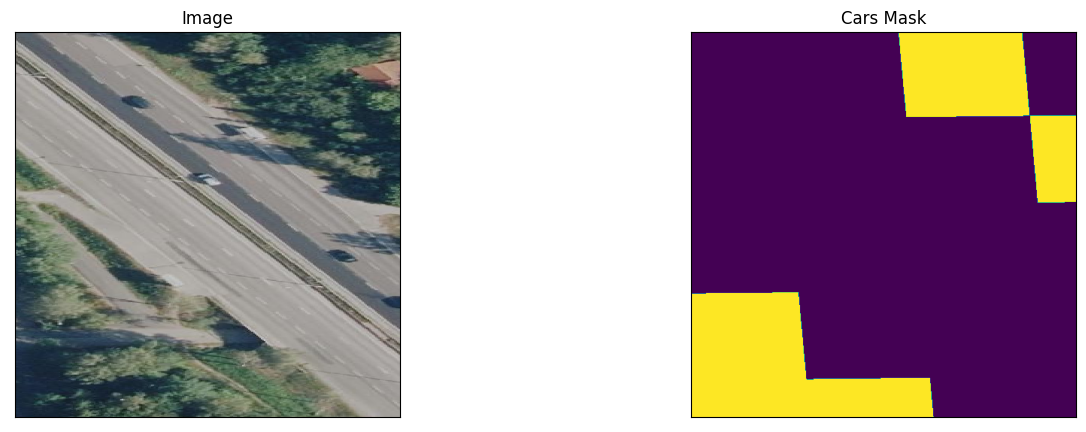

In [10]:
# Lets look at data we have

dataset = Dataset(img_dir, anno_dir, classes=['kussi'])

image, mask = dataset[20] # get some sample
visualize(
    image=image, 
    cars_mask=mask.squeeze(),
)

In [11]:
import albumentations as albu

def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=512, min_width=512, always_apply=True, border_mode=0),
        albu.RandomCrop(height=512, width=512, always_apply=True),

        albu.GaussNoise(p=0.2),
        albu.Perspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightnessContrast(p=1),
                albu.RandomGamma(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.Sharpen(p=1),
                # albu.Blur(blur_limit=2, p=1),
                # albu.MotionBlur(blur_limit=2, p=1),
            ],
            p=0.5,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(512, 512)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

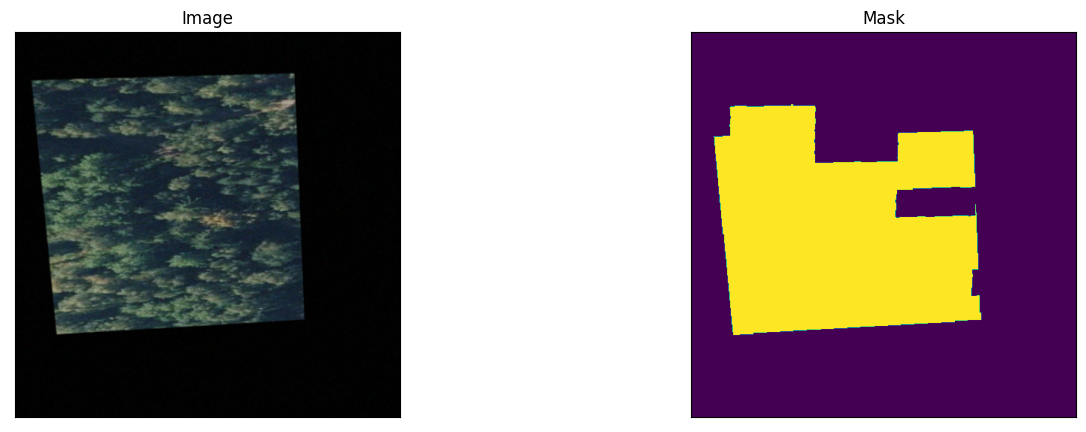

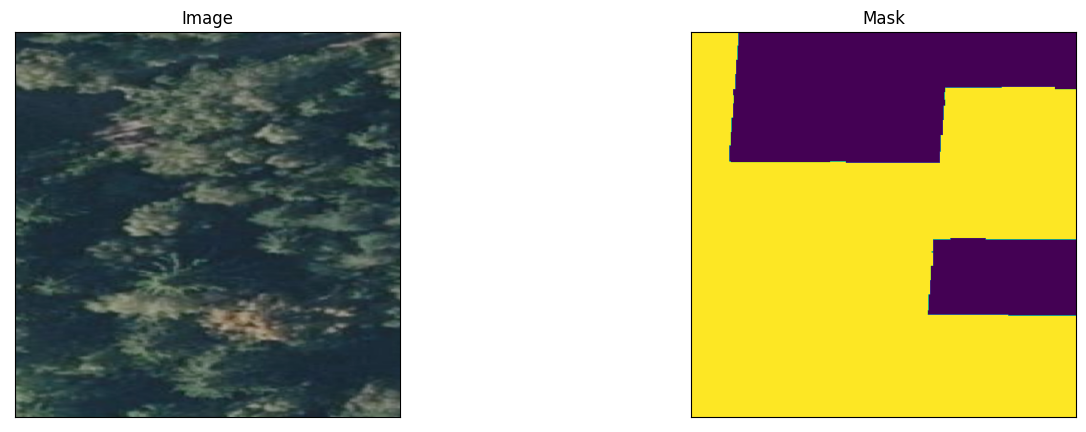

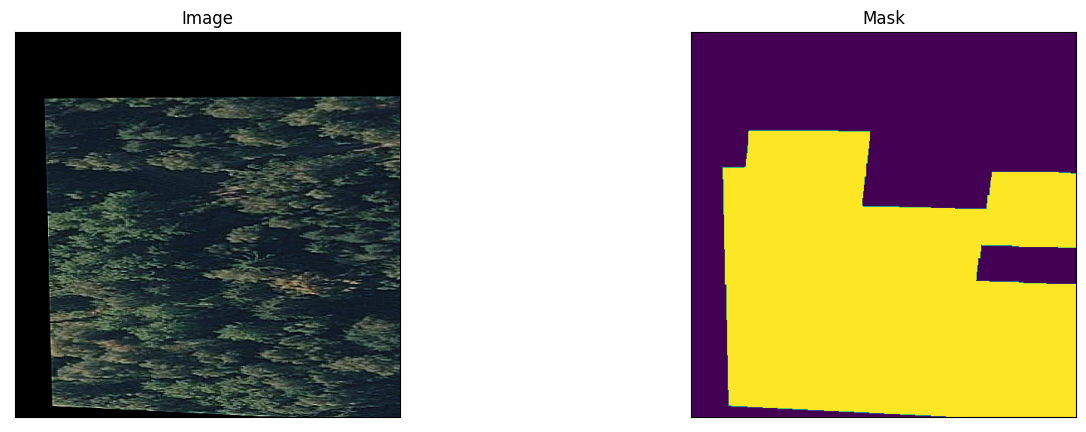

In [13]:
#### Visualize resulted augmented images and masks

augmented_dataset = Dataset(
    img_dir, 
    anno_dir, 
    augmentation=get_training_augmentation(), 
    classes=['kussi'],
)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[10]
    visualize(image=image, mask=mask.squeeze(-1))

In [14]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

ENCODER = 'timm-efficientnet-b8'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['kussi']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# create segmentation model with pretrained encoder
# MODEL_NAME = 'FPN'
model = smp.PSPNet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [15]:
train_dataset = Dataset(
    img_dir, 
    anno_dir, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
    val_img_dir, 
    val_anno_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=1)
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False, num_workers=1)

In [16]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

# loss = smp.utils.losses.DiceLoss()
from segmentation_models_pytorch import utils as smpu

loss = smp.losses.DiceLoss('binary')
loss.__name__ = 'focal_loss'
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples

train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [17]:
# train model for 40 epochs
import wandb
import random
# wandb.init(project='forest_patches', entity='linzh', name=f'{MODEL_NAME}-{int(random.random()*1000)}')
# wandb.watch(model, log='all')

max_score = 0

train_log_list = []
valid_log_list = []

for i in range(0, 25):
    print('\nEpoch: {}'.format(i+1))
    train_logs = train_epoch.run(train_loader)
    train_log_list.append(train_logs)
    print(train_logs)
    valid_logs = valid_epoch.run(valid_loader)
    valid_log_list.append(valid_logs)
    print(valid_logs)
    
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
    if i == 15:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')
    # do something (save model, change lr, etc.)
print(f'Max IOU: {max_score}')


Epoch: 1
train: 100%|██████████| 638/638 [04:52<00:00,  2.18it/s, focal_loss - 0.6324, iou_score - 0.4911]
{'focal_loss': 0.6324347466884367, 'iou_score': 0.49110059675106155}
valid: 100%|██████████| 319/319 [01:06<00:00,  4.80it/s, focal_loss - 0.0, iou_score - 1.172e-12]
{'focal_loss': 0.0, 'iou_score': 1.1722556606757045e-12}
Model saved!

Epoch: 2
train: 100%|██████████| 638/638 [04:36<00:00,  2.31it/s, focal_loss - 0.6284, iou_score - 0.5498]
{'focal_loss': 0.6283573752099819, 'iou_score': 0.5498280032146663}
valid: 100%|██████████| 319/319 [00:37<00:00,  8.61it/s, focal_loss - 0.0, iou_score - 4.762e-13]
{'focal_loss': 0.0, 'iou_score': 4.762242178519229e-13}

Epoch: 3
train: 100%|██████████| 638/638 [04:43<00:00,  2.25it/s, focal_loss - 0.6231, iou_score - 0.5676]
{'focal_loss': 0.6230828127704073, 'iou_score': 0.5675858725771061}
valid: 100%|██████████| 319/319 [00:37<00:00,  8.42it/s, focal_loss - 0.0, iou_score - 3.829e-13]
{'focal_loss': 0.0, 'iou_score': 3.8292578925981575

KeyboardInterrupt: 

In [ ]:
print(f'Max IOU: {max_score}')

In [18]:
# load best saved checkpoint
best_model = torch.load('./best_model.pth')

In [19]:
# create test dataset
test_dataset = Dataset(
    val_img_dir, 
    val_anno_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset)

In [20]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 1273/1273 [00:41<00:00, 30.94it/s, focal_loss - 0.0, iou_score - 0.2443]


In [21]:
# test dataset without transformations for image visualization
test_dataset_vis = Dataset(
    val_img_dir, val_anno_dir, 
    classes=CLASSES,
)

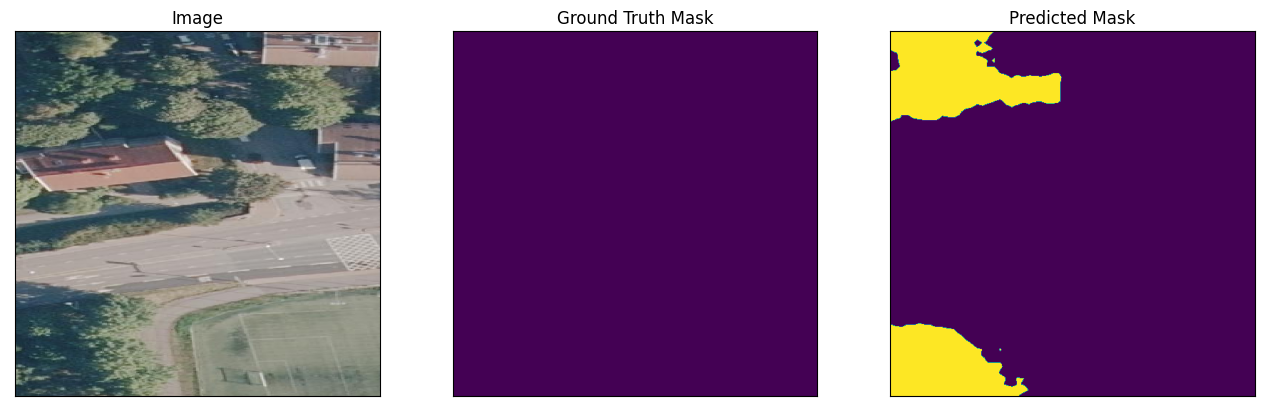

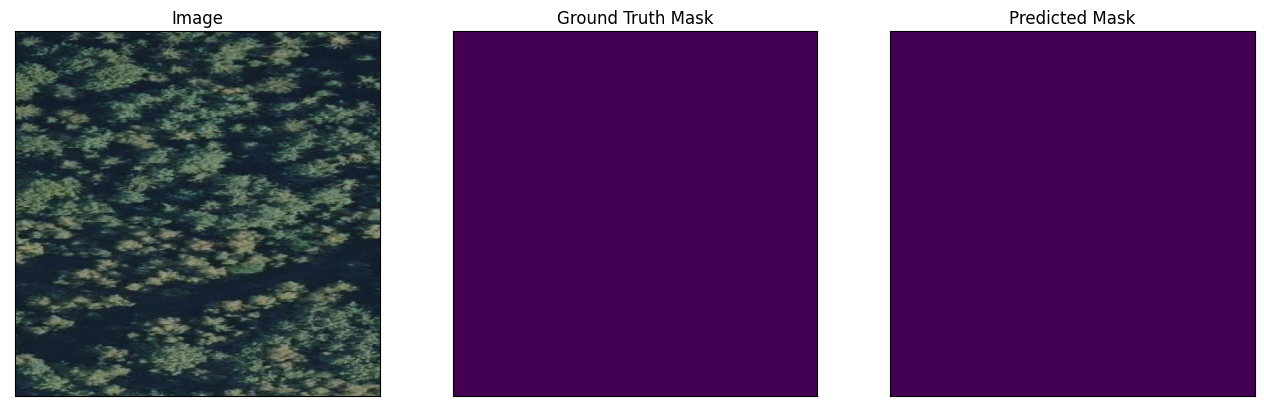

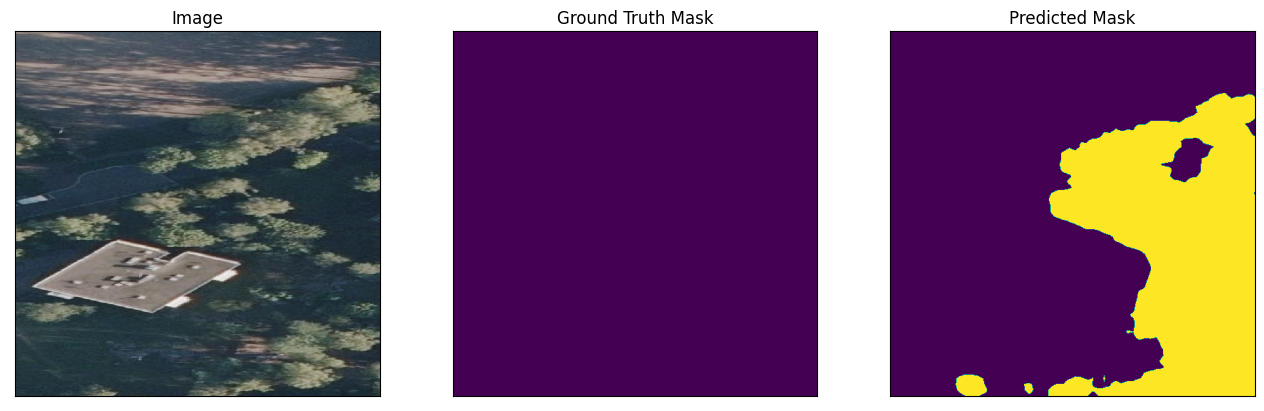

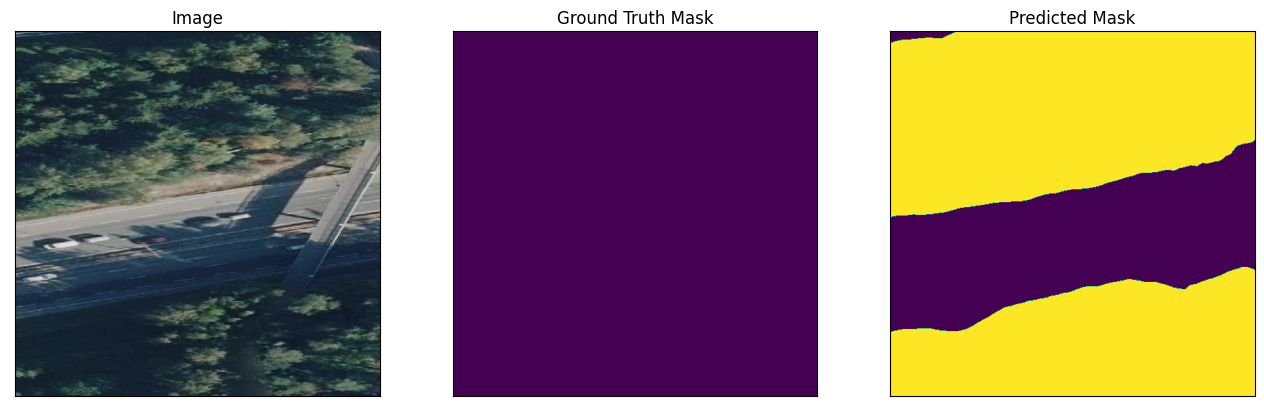

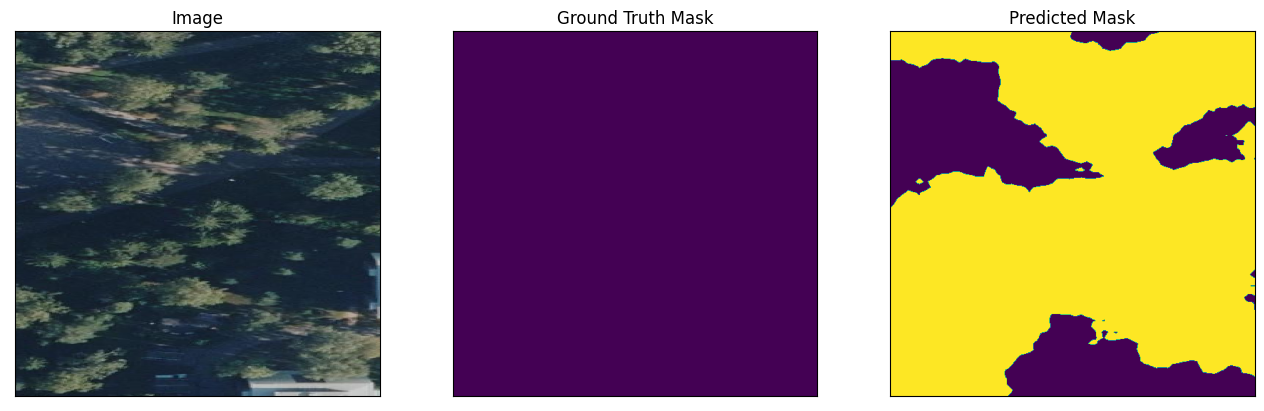

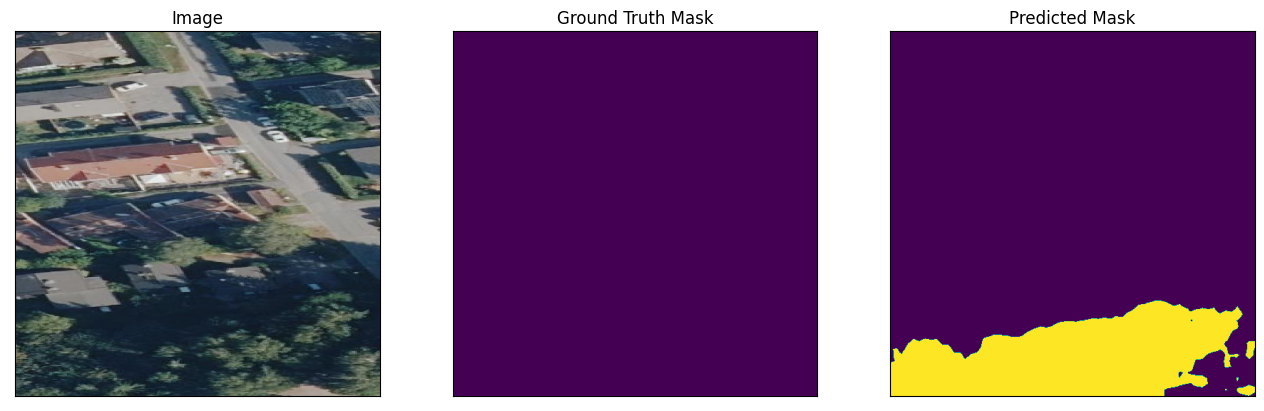

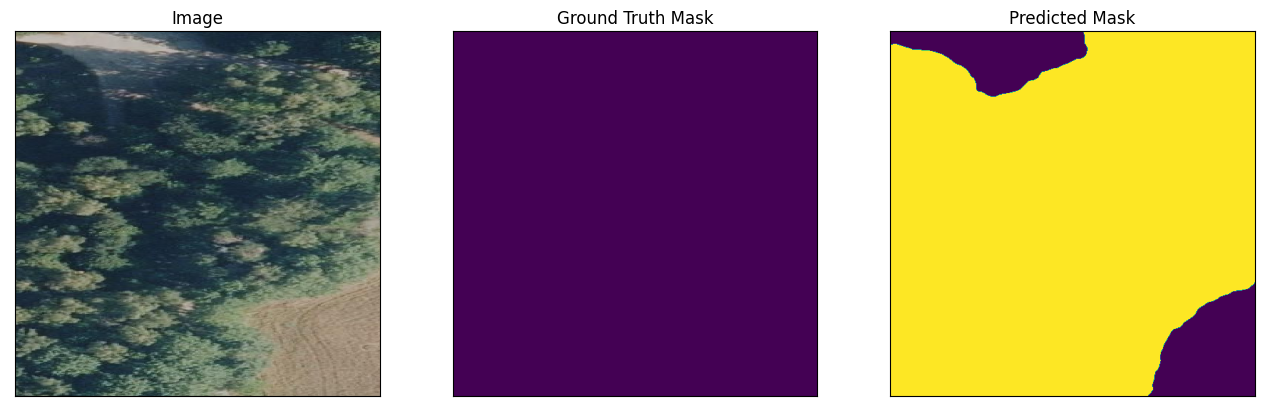

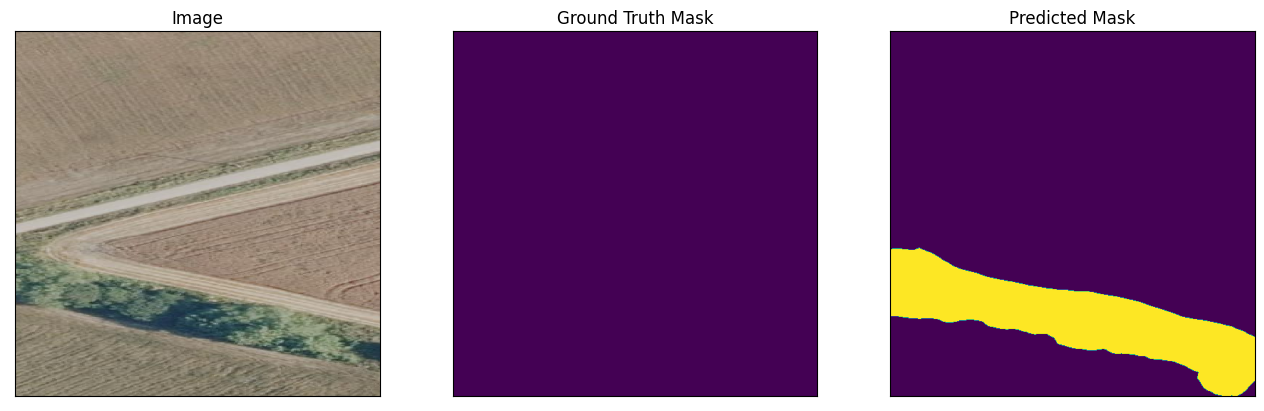

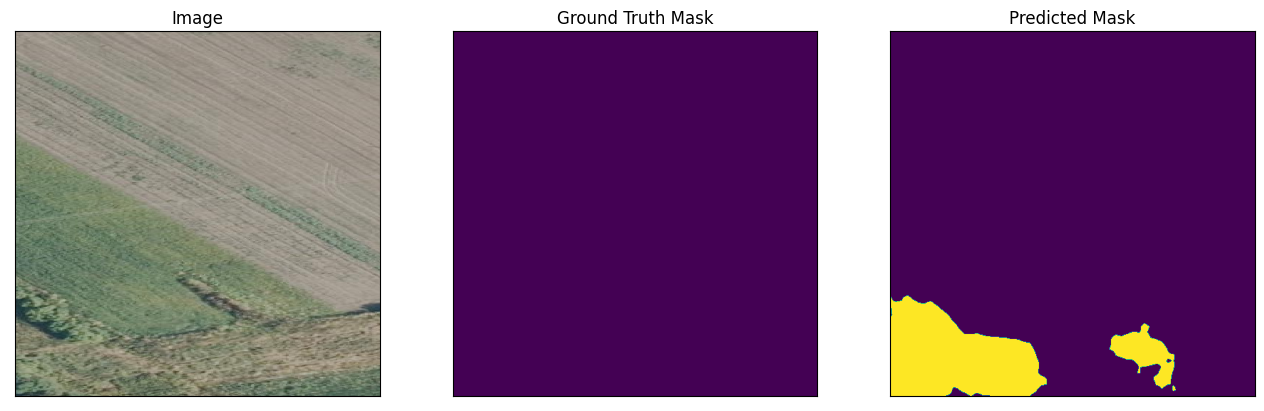

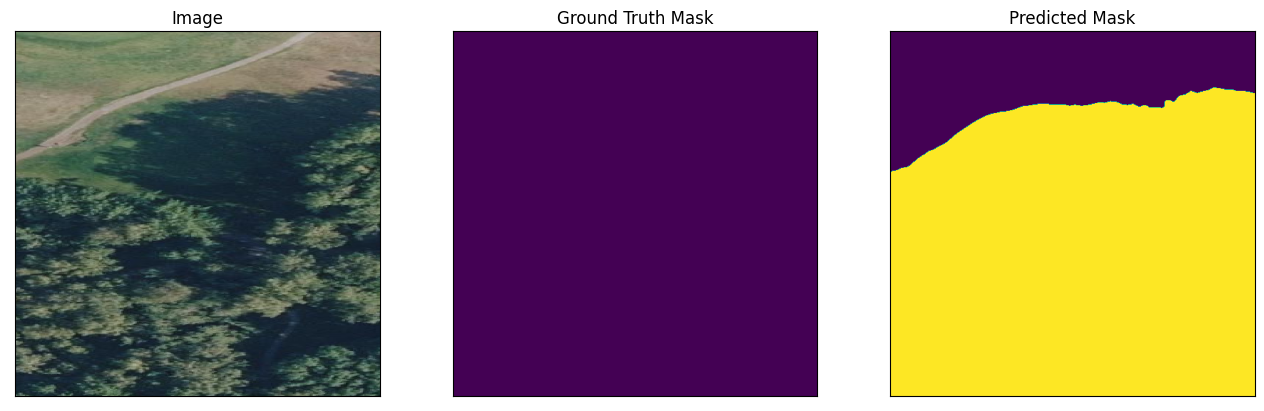

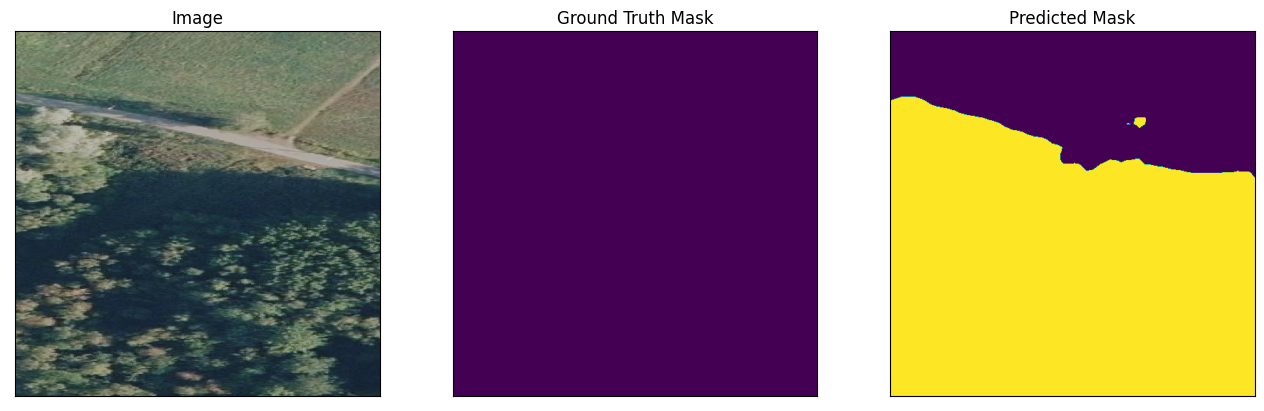

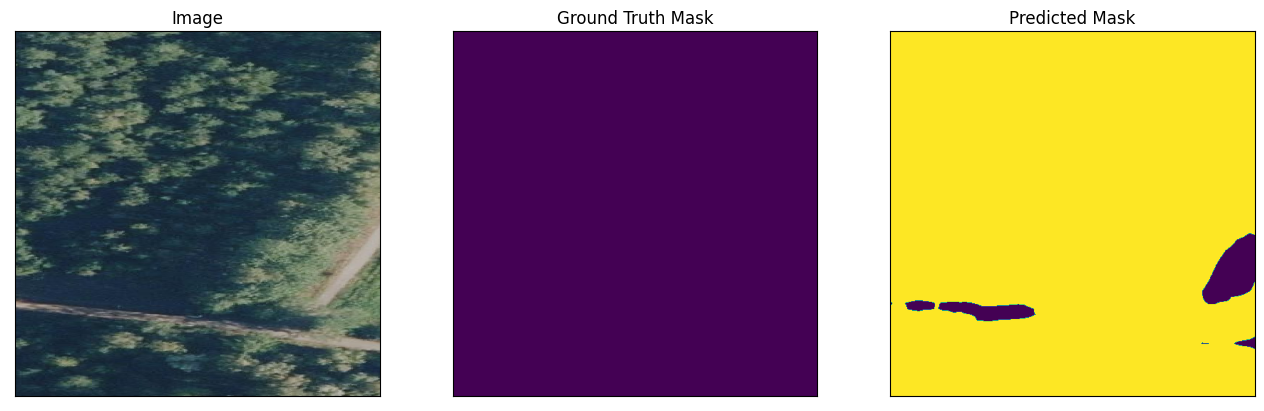

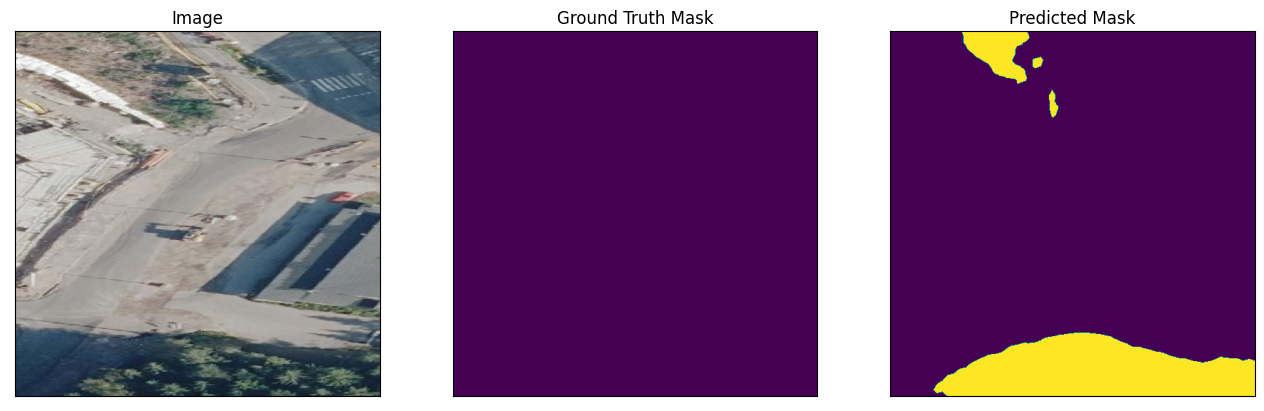

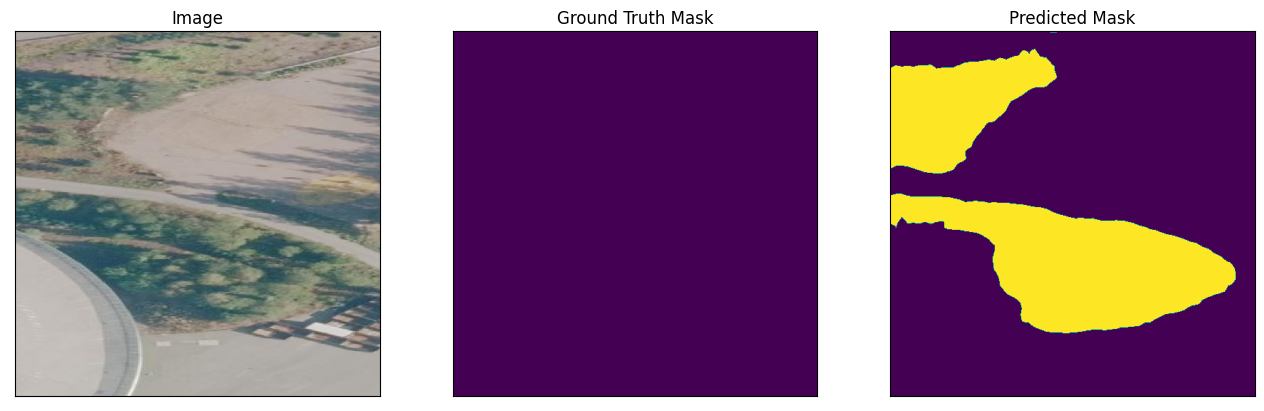

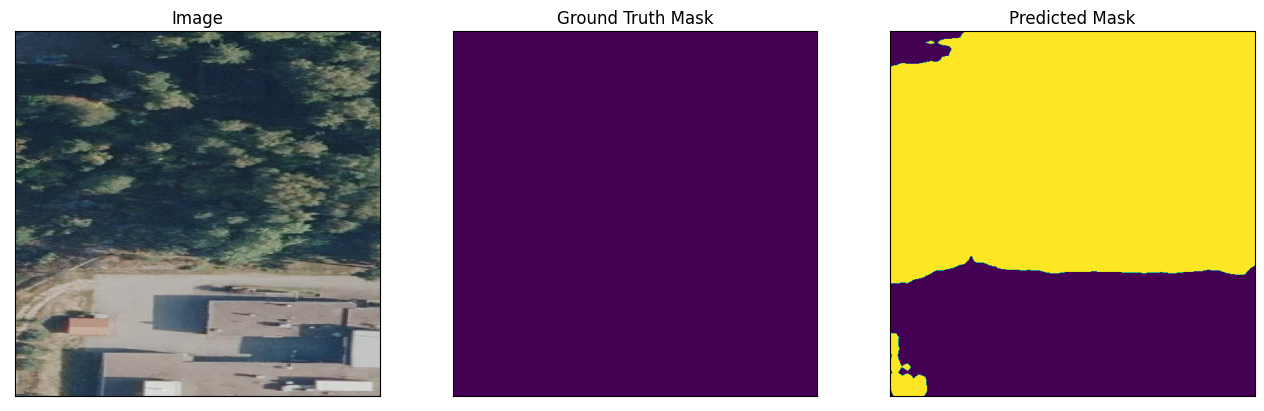

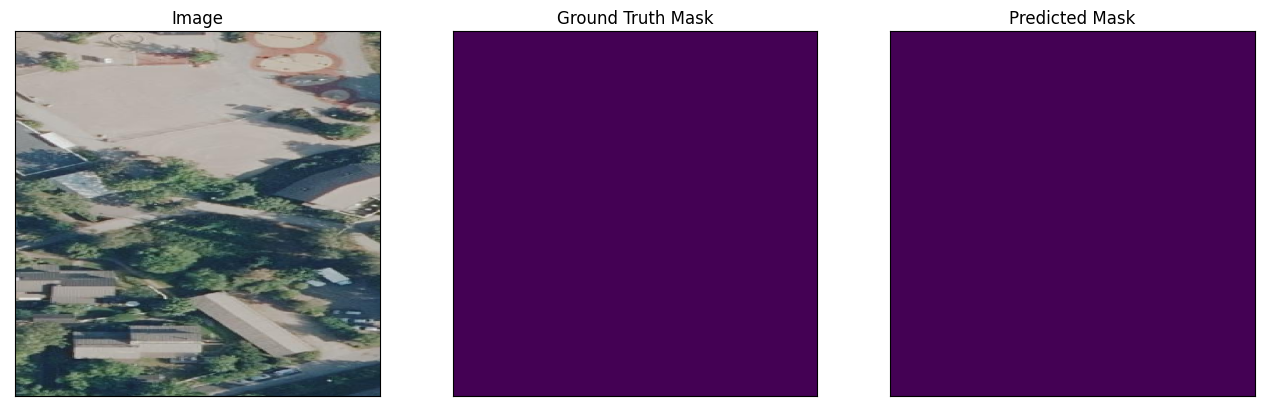

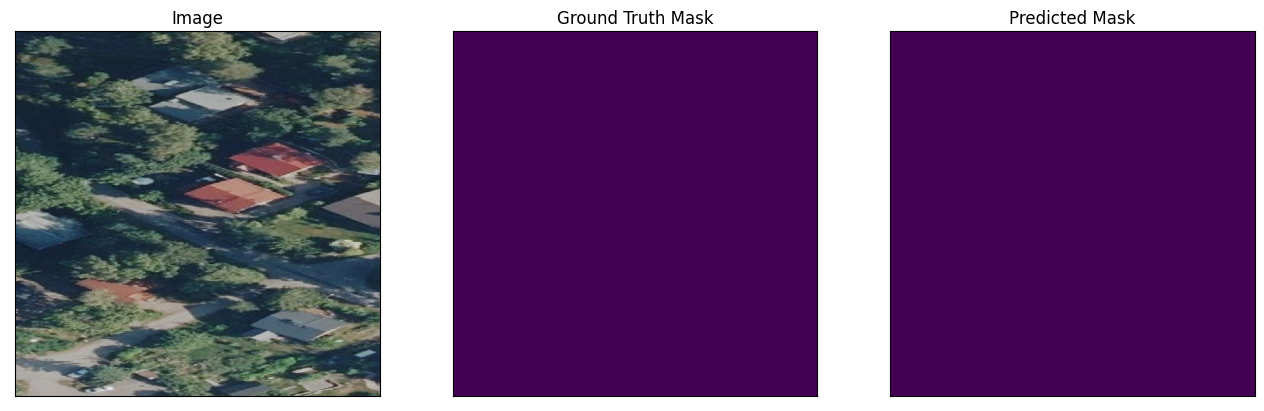

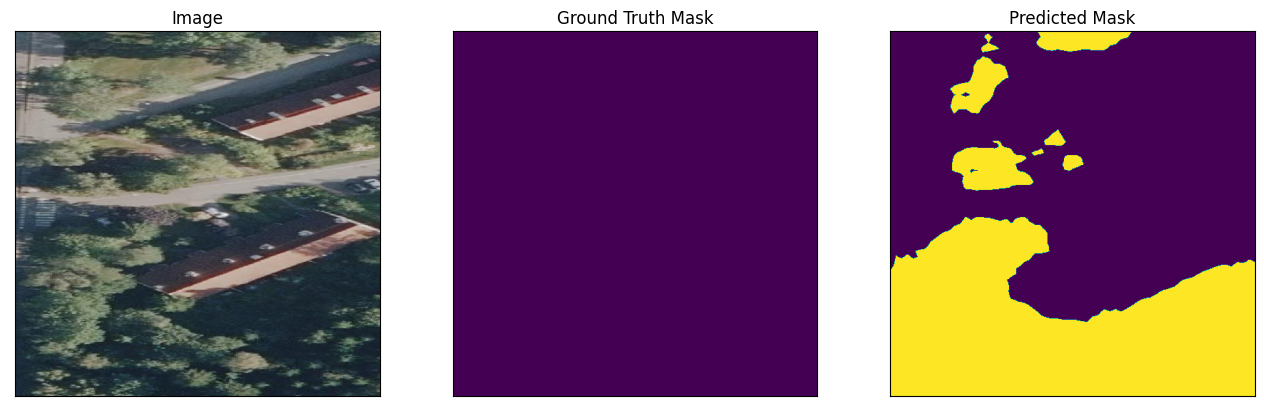

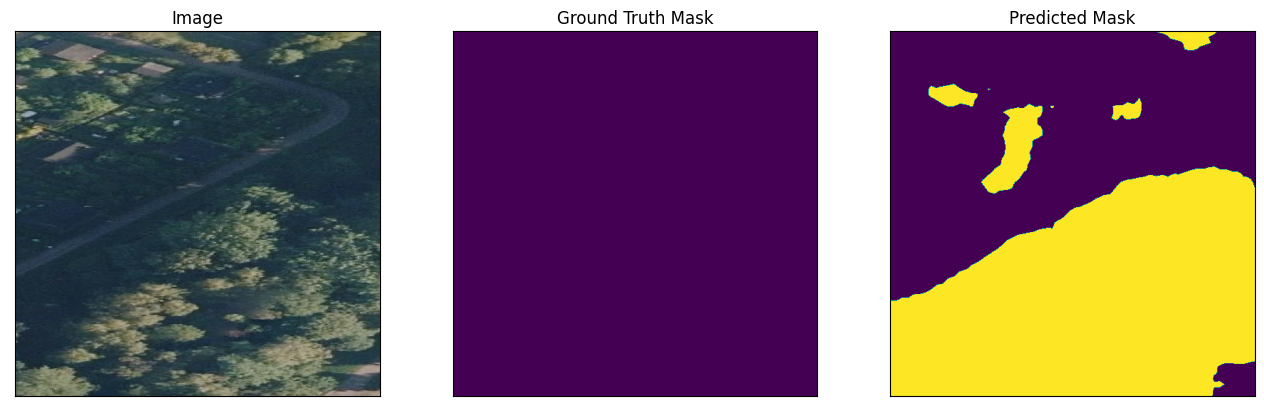

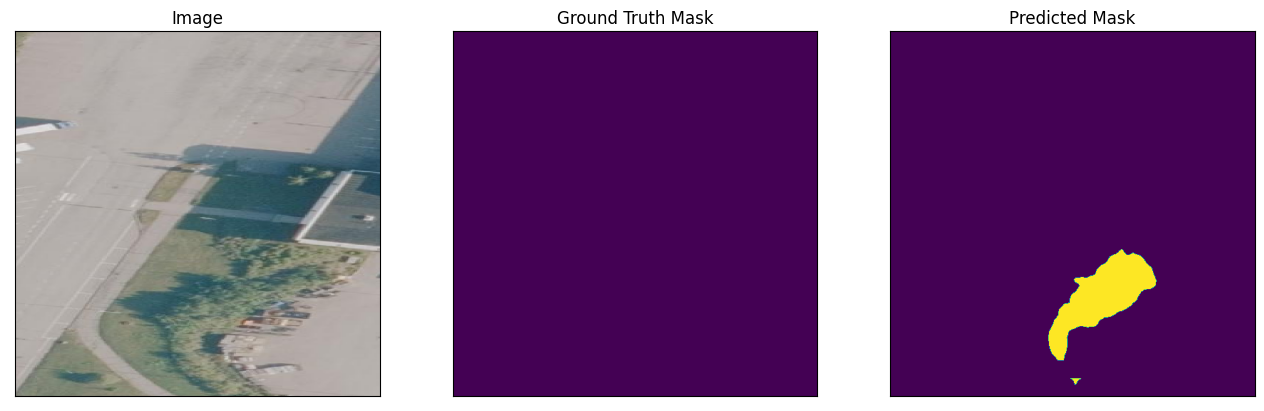

In [22]:
for i in range(20):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
        
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )